# Implementing the Fastai Learner from scratch 

In [1]:
from fastai2.vision.all import *

matplotlib.rc('image', cmap='Greys')

## Get the data 

In [2]:
path = untar_data(URLs.MNIST)

In [3]:
Path.BASE_PATH = path
path.ls()

(#2) [Path('training'),Path('testing')]

In [4]:
(path/'training').ls()

(#10) [Path('training/0'),Path('training/2'),Path('training/9'),Path('training/8'),Path('training/7'),Path('training/1'),Path('training/5'),Path('training/4'),Path('training/6'),Path('training/3')]

In [5]:
dls = ImageDataLoaders.from_folder(path, train='training', valid='testing')

In [6]:
im, l = first(dls.train)

In [7]:
im.shape

torch.Size([64, 3, 28, 28])

In [8]:
l.shape

torch.Size([64])

In [9]:
l

TensorCategory([8, 1, 9, 4, 4, 1, 3, 6, 7, 7, 7, 6, 0, 1, 3, 0, 7, 8, 7, 5, 1, 8, 2, 4,
        5, 6, 5, 9, 4, 4, 5, 0, 2, 3, 6, 9, 8, 9, 4, 1, 4, 7, 4, 8, 7, 3, 6, 8,
        9, 4, 1, 3, 1, 5, 8, 5, 9, 7, 9, 2, 6, 8, 1, 0], device='cuda:0')

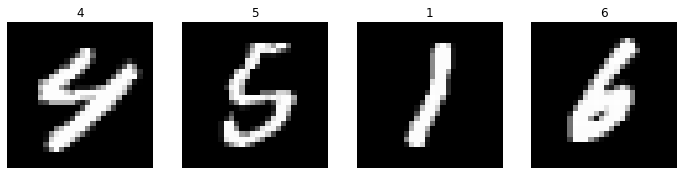

In [10]:
dls.show_batch(max_n=4, nrows=1)

Let's look at what a Learner object requires:

<img src='images/learner.png' />

Some of these are parameters are for quite advanced functionalities but basically we need:
   - a DataLoaders object containing a training DataLoader and a validation DataLoader
   - a model we want to train
   - a loss function
   - an optimizer
   - a learning rate for the optimizer and 
   - some metrics to be used to evaluate the model on the validation set

### *The model*

In [11]:
model = nn.Sequential(
            nn.Conv2d(3, 32, 3),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.4),
            nn.Flatten(),
            nn.Linear(9216, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 10))

In [12]:
model.cuda();

### *The metric*

Let's define a function to find the accuracy

In [13]:
def cal_accuracy(preds, targets):
    preds = preds.softmax(dim=1)
    return (preds.argmax(dim=1) == targets).float().mean()

For the loss function, we use the the cross entropy loss function provided by PyTorch, ie. `F.cross_entropy`

### *The loss function*

In [14]:
def cross_entropy(preds, targets):
    preds = preds.softmax(dim=1)
    rows = torch.arange(preds.shape[0])
    return -(preds[rows, targets]).log().mean()

### *Learner*

In [15]:
class BasicLearner:
    def __init__(self, dls, model, loss_func, opt_func, lr, metric):
        self.model = model
        self.dls = dls
        self.loss_func = loss_func
        self.optim = opt_func(model.parameters(), lr)
        self.lr = lr
        self.metric = metric
    
    def fit(self, epochs):
        print(f'Epoch Train_loss  Valid_loss  {self.metric.__name__}')
        for epoch in range(epochs):
            # train
            trn_loss = self.train_epoch()
            # validate
            val_loss, met = self.validate_epoch()
            print(f'{epoch+1}\t{trn_loss:.4f}\t   {val_loss:.4f}\t{met:.4f}')
    
    def train_epoch(self):
        losses = []
        for xb, yb in self.dls.train:
            losses.append(self.calc_grad(xb, yb))
            self.optim.step()
            self.optim.zero_grad()
        return torch.stack(losses).mean()
        
    def calc_grad(self, xb, yb):
        preds = self.model(xb)
        loss = self.loss_func(preds, yb)
        loss.backward()
        return loss
    
    def validate_epoch(self):
        losses = []
        mets = []
        with torch.no_grad():
            for xb, yb in self.dls.valid:
                preds = self.model(xb)
                losses.append(self.loss_func(preds, yb))
                mets.append(self.metric(preds, yb))
        return torch.stack(losses).mean(), torch.stack(mets).mean()
                
                

In [16]:
learn = BasicLearner(dls, model, cross_entropy, SGD, 1e-3, cal_accuracy)

In [17]:
learn.fit(10)

Epoch Train_loss  Valid_loss  cal_accuracy
1	2.2573	   2.1631	0.4972
2	1.6147	   0.8810	0.7602
3	0.6673	   0.5268	0.8461
4	0.4935	   0.4369	0.8751
5	0.4271	   0.3806	0.8924
6	0.3856	   0.3442	0.9012
7	0.3505	   0.3187	0.9077
8	0.3263	   0.2989	0.9137
9	0.3035	   0.2826	0.9182
10	0.2850	   0.2657	0.9236
